# Financial Time-Series Forecasting

This notebook walks through the process of creating additive models for time-series data in Python. In particular, we use the Facebook Prophet package and financial data from quandl. 

In [173]:
# quandly for financial data
import quandl
# pandas for data manipulation
import pandas as pd

In [174]:
# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [175]:
import warnings
warnings.filterwarnings("ignore")

# Retrieve Data from Quandl

We will explore the market capitalization of two American car companies, GM and Tesla. You can make 50 calls to quandl a day with no api key, or create a free account to make unlimited calls per day. 

In [176]:
########
quandl.ApiConfig.api_key = 'zjsWNmzXjTz9DYygZPgY'

# Retrieve TSLA data from Quandl
tesla = quandl.get('WIKI/TSLA')

# Retrieve the GM data from Quandl
gm = quandl.get('WIKI/GM')
gm.head(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-11-18,35.00,35.99,33.89,34.19,457044300.0,0.0,1.0,29.988317,30.836558,29.037259,29.294302,457044300.0
2010-11-19,34.15,34.50,33.11,34.26,107842000.0,0.0,1.0,29.260029,29.559912,28.368948,29.354278,107842000.0
2010-11-22,34.20,34.48,33.81,34.08,36650600.0,0.0,1.0,29.302870,29.542776,28.968714,29.200053,36650600.0
2010-11-23,33.95,33.99,33.19,33.25,31170200.0,0.0,1.0,29.088668,29.122940,28.437493,28.488901,31170200.0
2010-11-24,33.73,33.80,33.22,33.48,26138000.0,0.0,1.0,28.900170,28.960146,28.463197,28.685967,26138000.0


### Quick Visualization of the Data

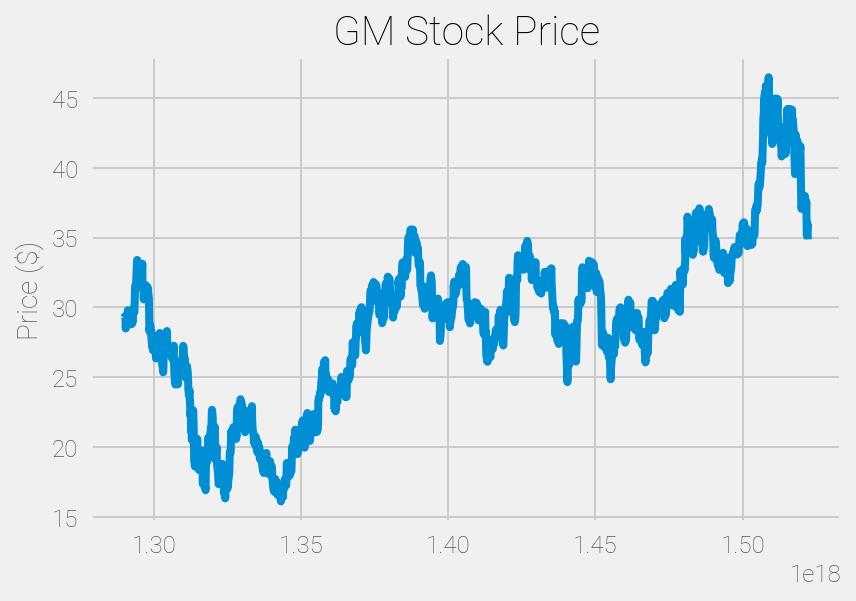

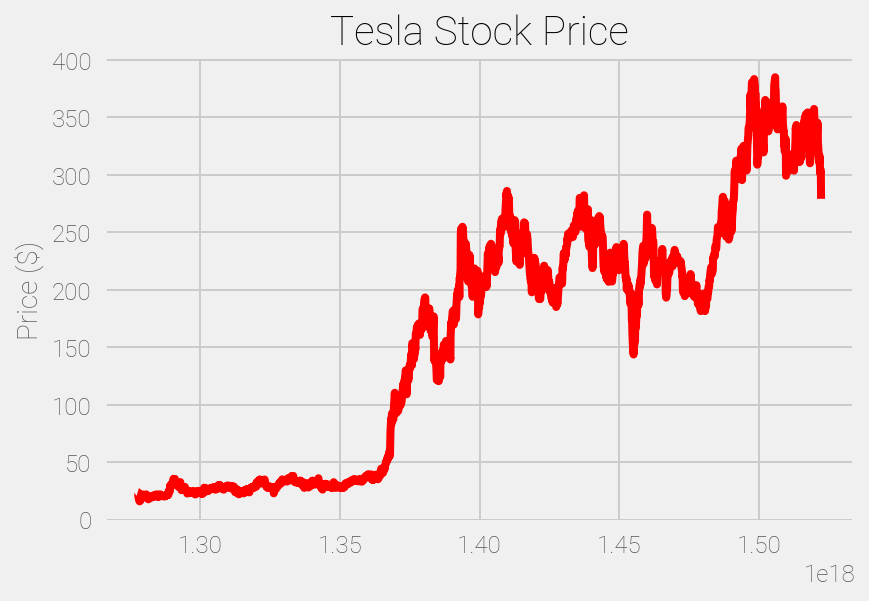

In [177]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(gm.index, gm['Adj. Close'])
plt.title('GM Stock Price')
plt.ylabel('Price ($)');
plt.show()

plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)');
plt.show();

In order to compare the companies, we need to compute their market capitalization. Quandl does not provide this data, but we can figure out the market cap ourselves by multiplying the average number of shares outstanding in each year times the share price. 

In [178]:
# Yearly average number of shares outstanding for Tesla and GM
tesla_shares = {2018: 168e6, 2017: 162e6, 2016: 144e6, 2015: 128e6, 2014: 125e6, 
                2013: 119e6, 2012: 107e6, 2011: 100e6, 2010: 51e6}

gm_shares = {2018: 1.42e9, 2017: 1.50e9, 2016: 1.54e9, 2015: 1.59e9, 2014: 1.61e9, 
                2013: 1.39e9, 2012: 1.57e9, 2011: 1.54e9, 2010: 1.50e9}

#### Calculate Market Capitalization

In [179]:
# Create a year column 
tesla['Year'] = tesla.index.year

# Take Dates from index and move to Date column 
tesla.reset_index(inplace = True)
tesla['cap'] = 0

# Calculate market cap for all years
for i, year in enumerate(tesla['Year']):
    # Retrieve the shares for the year
    shares = tesla_shares.get(year)
    
    # Update the cap column to shares times the price
    tesla.ix[i, 'cap'] = shares * tesla.ix[i, 'Adj. Close']

In [180]:
# Create a year column 
gm['Year'] = gm.index.year

# Take Dates from index and move to Date column 
gm.reset_index(inplace = True)
gm['cap'] = 0

# Calculate market cap for all years
for i, year in enumerate(gm['Year']):
    # Retrieve the shares for the year
    shares = gm_shares.get(year)
    
    # Update the cap column to shares times the price
    gm.ix[i, 'cap'] = shares * gm.ix[i, 'Adj. Close']

In [181]:
# Merge the two datasets and rename the columns
cars = gm.merge(tesla, how='inner', on='Date')
cars.rename(columns={'cap_x': 'gm_cap', 'cap_y': 'tesla_cap'}, inplace=True)

In [182]:
# Select only the relevant columns
cars = cars.ix[:, ['Date', 'gm_cap', 'tesla_cap']]

# Divide to get market cap in billions of dollars
cars['gm_cap'] = cars['gm_cap'] / 1e9
cars['tesla_cap'] = cars['tesla_cap'] / 1e9

cars.head()

,Date,gm_cap,tesla_cap
0,2010-11-18,43.941453,1.52439
1,2010-11-19,44.031417,1.58049
2,2010-11-22,43.800079,1.70340
3,2010-11-23,42.733352,1.76307
4,2010-11-24,43.028951,1.80897


### Visual Comparison

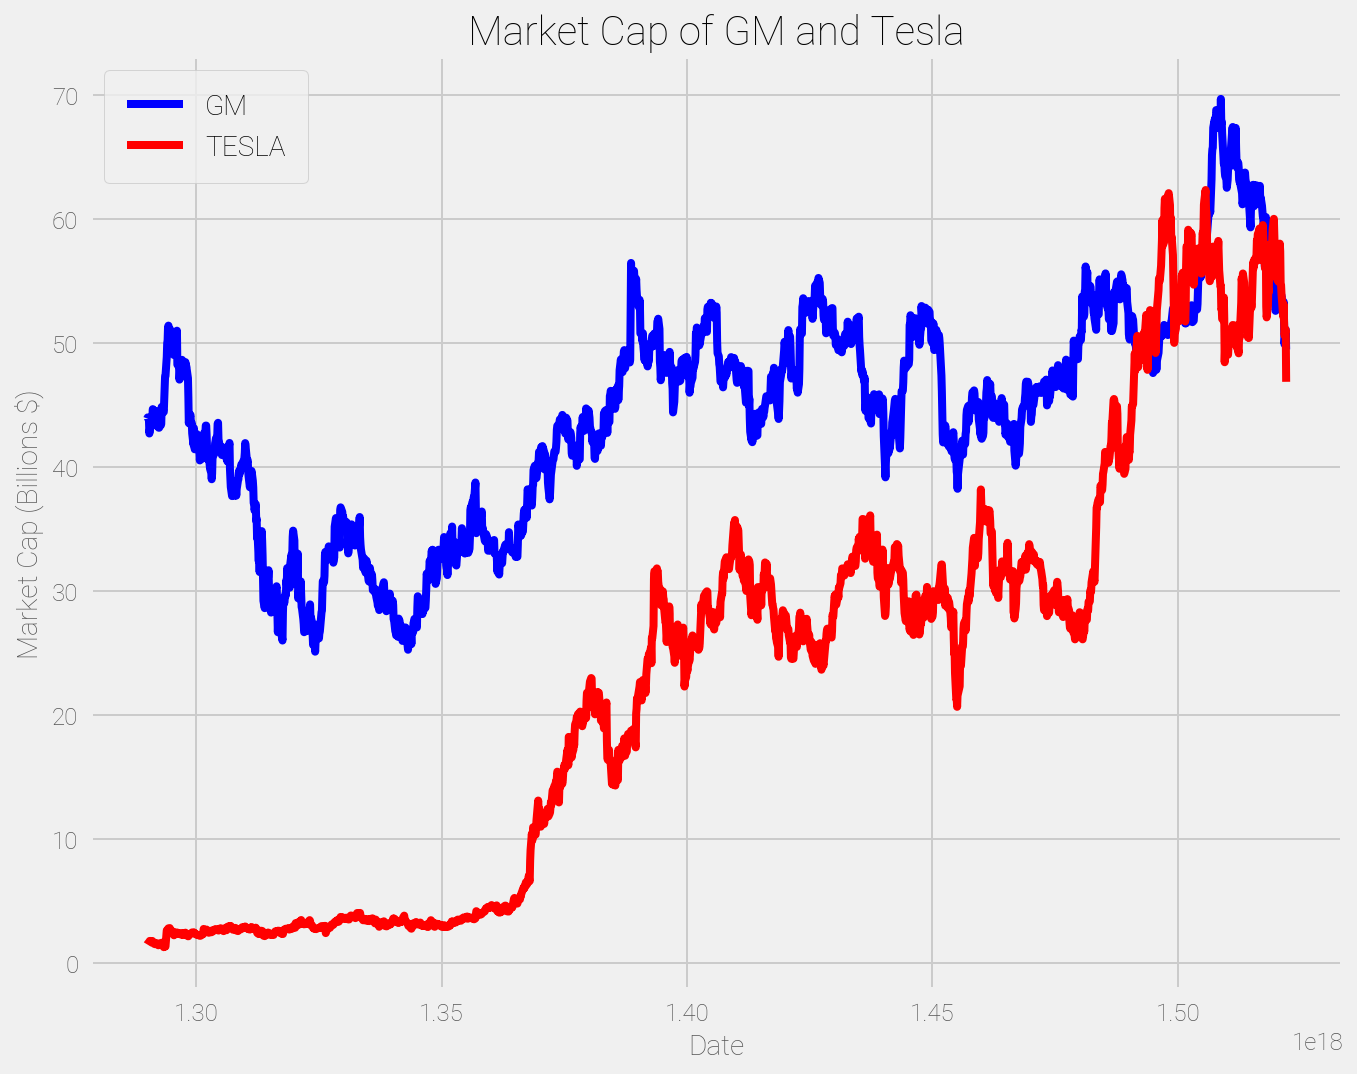

In [183]:
plt.figure(figsize=(10, 8))
plt.plot(cars['Date'], cars['gm_cap'], 'b-', label = 'GM')
plt.plot(cars['Date'], cars['tesla_cap'], 'r-', label = 'TESLA')
plt.xlabel('Date'); plt.ylabel('Market Cap (Billions $)'); plt.title('Market Cap of GM and Tesla')
plt.legend();

Tesla briefly surpassed GM in market cap in 2017. When did this occur?

In [184]:
import numpy as np

# Find the first and last time Tesla was valued higher than GM
first_date = cars.ix[np.min(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']
last_date = cars.ix[np.max(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']

print("Tesla was valued higher than GM from {} to {}.".format(first_date.date(), last_date.date()))

Tesla was valued higher than GM from 2017-04-10 to 2018-03-23.


During Q2 2017, Tesla [sold](https://en.wikipedia.org/wiki/Tesla,_Inc.#Production_and_sales) 22026 cars while GM [sold](http://gmauthority.com/blog/gm/general-motors-sales-numbers/) 725000. In Q3 2017, Tesla sold 26137 cars and GM sold 808000. In all of 2017, Tesla sold 103084 cars and GM sold 3002237. That means GM was valued less than Tesla in a year during which it sold 29 times more cars than Tesla! Interesting to say the least.

# Prophet Models 

In [185]:
import fbprophet

# Prophet requires columns ds (Date) and y (value)
gm = gm.rename(columns={'Date': 'ds', 'cap': 'y'})
# Put market cap in billions
gm['y'] = gm['y'] / 1e9

# Make the prophet models and fit on the data
# changepoint_prior_scale can be changed to achieve a better fit
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
gm_prophet.fit(gm)

# Repeat for the tesla data
tesla =tesla.rename(columns={'Date': 'ds', 'cap': 'y'})
tesla['y'] = tesla['y'] / 1e9
tesla_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05, n_changepoints=10)
tesla_prophet.fit(tesla);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Predictions for 2 Years

In [186]:
# Make a future dataframe for 2 years
gm_forecast = gm_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

tesla_forecast = tesla_prophet.make_future_dataframe(periods=365*2, freq='D')
tesla_forecast = tesla_prophet.predict(tesla_forecast)

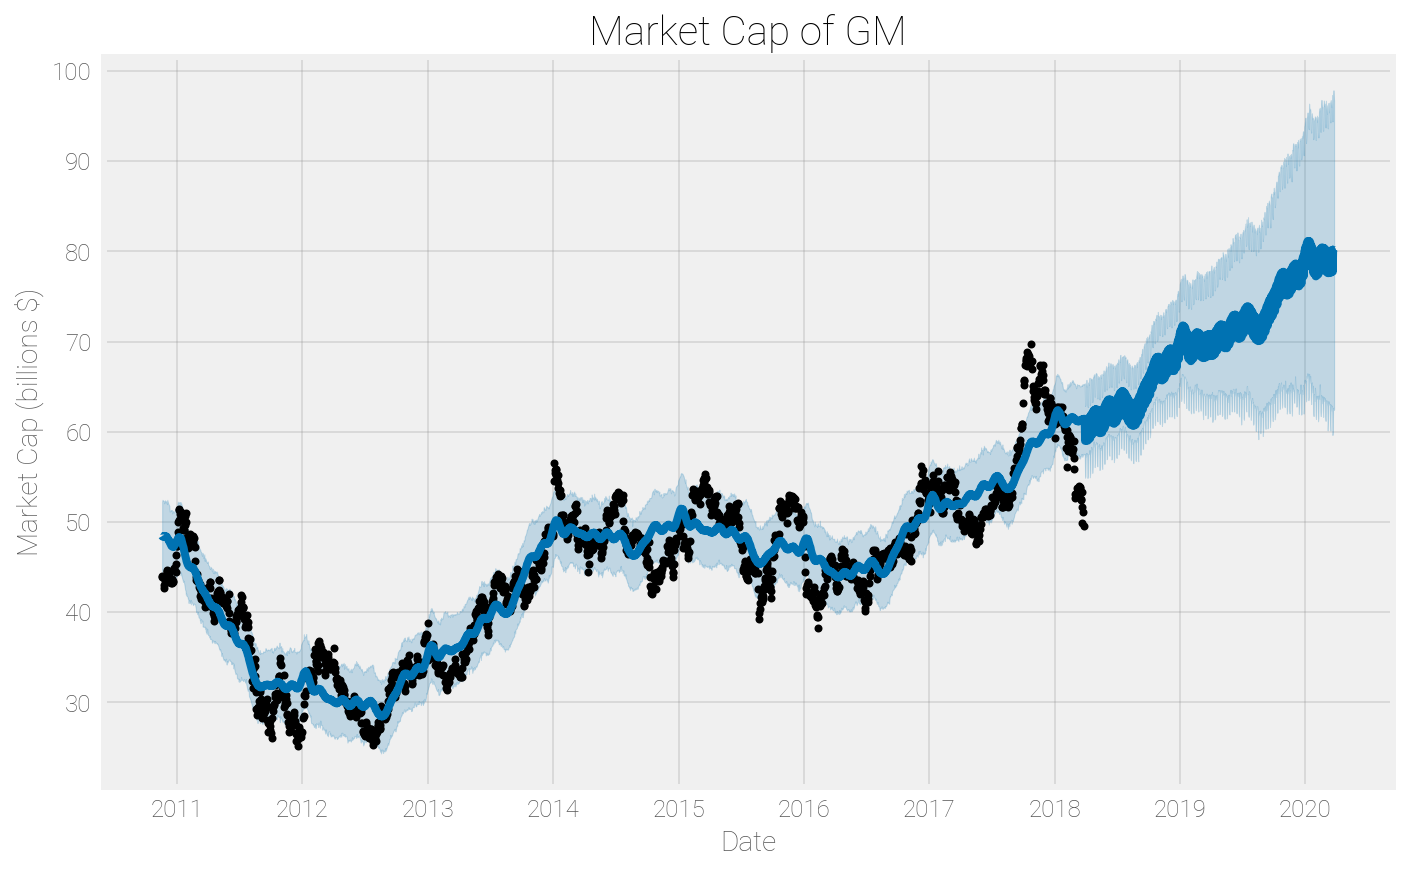

In [187]:
gm_prophet.plot(gm_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of GM');

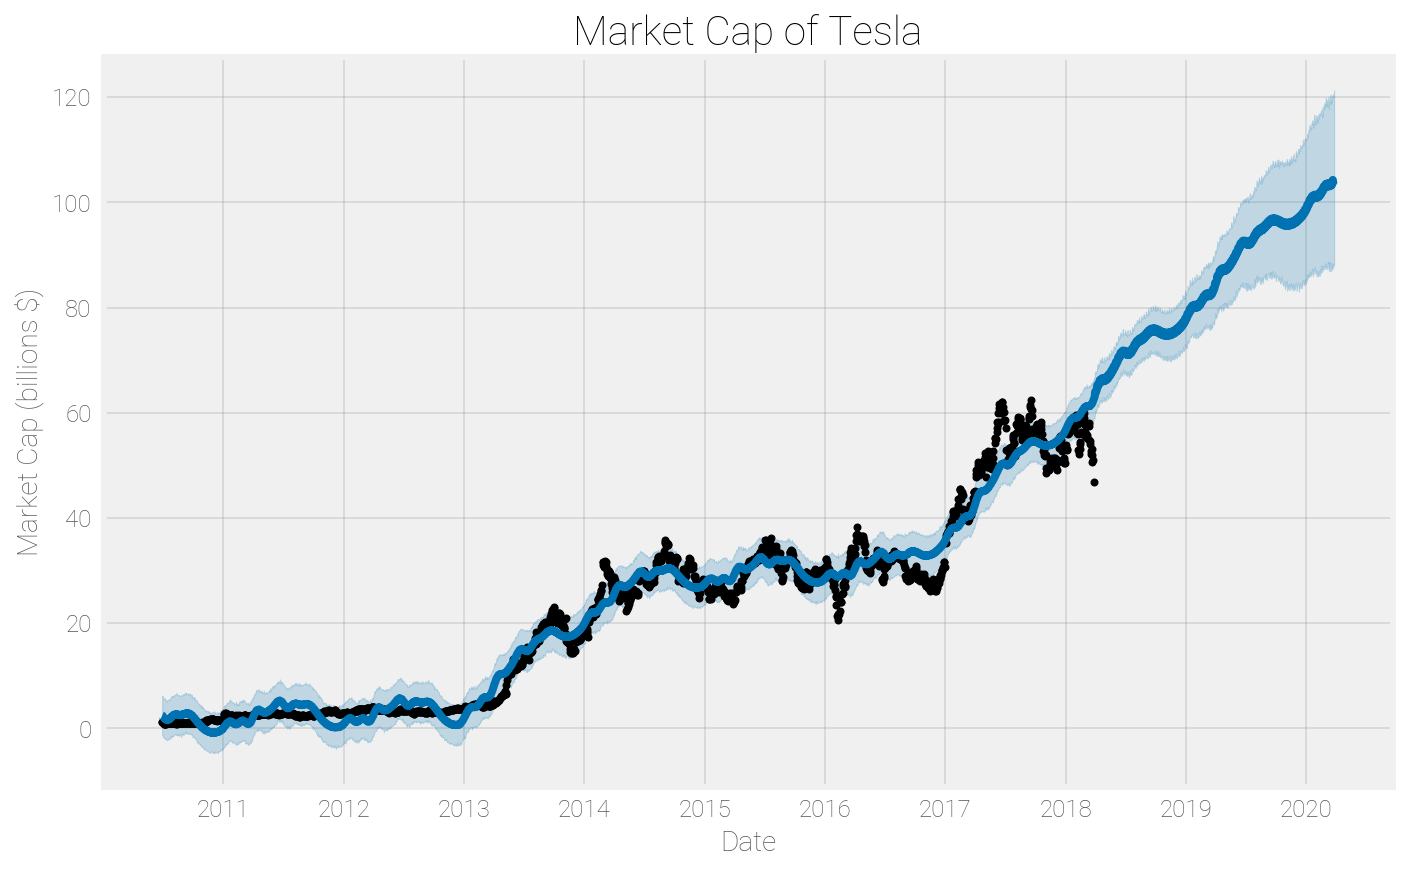

In [188]:
tesla_prophet.plot(tesla_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Tesla');

## Effect of Changepoint Prior Scale

In [189]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(tesla)
    
    future = model.make_future_dataframe(periods=365, freq='D')
    future = model.predict(future)
    
    tesla[changepoint] = future['yhat']

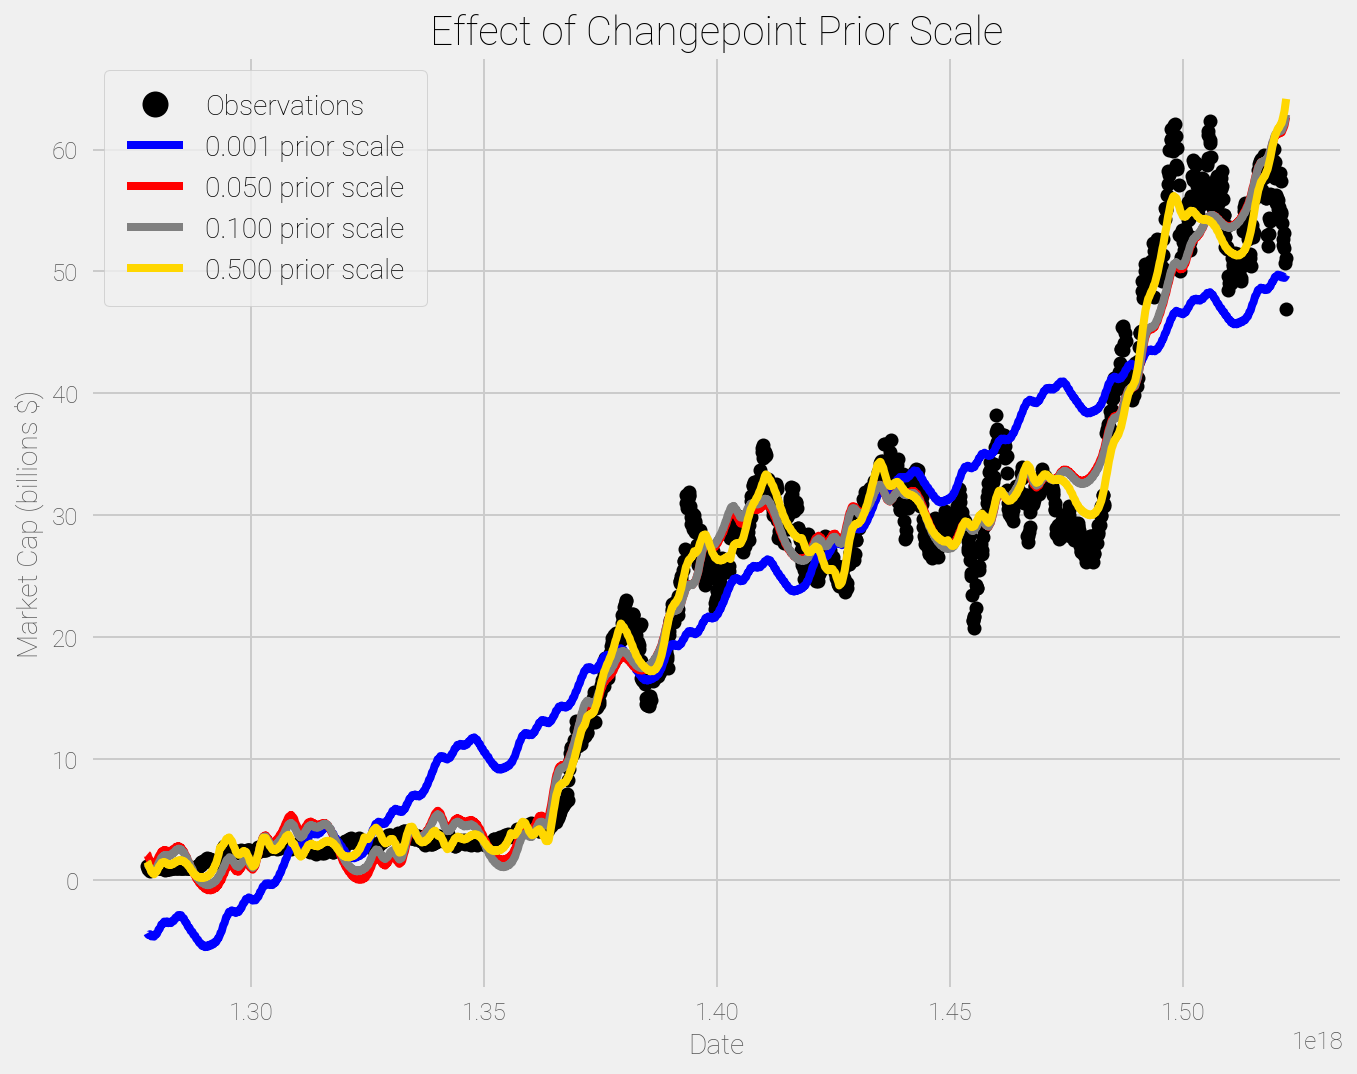

In [190]:
# Create the plot
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(tesla['ds'], tesla['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(tesla['ds'], tesla[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)'); plt.title('Effect of Changepoint Prior Scale');

In [191]:
gm_prophet.changepoints[:10]

59    2011-02-14
118   2011-05-10
177   2011-08-03
236   2011-10-26
296   2012-01-24
355   2012-04-18
414   2012-07-12
473   2012-10-04
532   2013-01-02
591   2013-03-28
Name: ds, dtype: datetime64[ns]

In [192]:
tesla_prophet.changepoints[:10]

156    2011-02-09
312    2011-09-22
467    2012-05-04
623    2012-12-18
779    2013-08-02
935    2014-03-18
1091   2014-10-28
1246   2015-06-11
1402   2016-01-25
1558   2016-09-06
Name: ds, dtype: datetime64[ns]

# Compare Forecasts

We want to determine when Tesla will overtake GM in total market value. We already have the forecasts for two years into the future. We will now join them together and determine when the model predicts Tesla will pull ahead. 

In [193]:
gm_names = ['gm_%s' % column for column in gm_forecast.columns]
tesla_names = ['tesla_%s' % column for column in tesla_forecast.columns]

# Dataframes to merge
merge_gm_forecast = gm_forecast.copy()
merge_tesla_forecast = tesla_forecast.copy()

# Rename the columns
merge_gm_forecast.columns = gm_names
merge_tesla_forecast.columns = tesla_names

In [194]:
# Merge the two datasets
forecast = pd.merge(merge_gm_forecast, merge_tesla_forecast, how = 'inner', left_on = 'gm_ds', right_on = 'tesla_ds')

# Rename date column
forecast = forecast.rename(columns={'gm_ds': 'Date'}).drop('tesla_ds', axis=1)
forecast.head()

,Date,gm_trend,gm_yhat_lower,gm_yhat_upper,gm_trend_lower,gm_trend_upper,gm_additive_terms,gm_additive_terms_lower,gm_additive_terms_upper,gm_weekly,...,tesla_weekly,tesla_weekly_lower,tesla_weekly_upper,tesla_yearly,tesla_yearly_lower,tesla_yearly_upper,tesla_multiplicative_terms,tesla_multiplicative_terms_lower,tesla_multiplicative_terms_upper,tesla_yhat
0,2010-11-18,47.110587,44.334220,52.276231,47.110587,47.110587,1.330294,1.330294,1.330294,0.725084,...,-0.190310,-0.190310,-0.190310,-2.285310,-2.285310,-2.285310,0.0,0.0,0.0,-0.683999
1,2010-11-19,47.069158,44.725948,52.461406,47.069158,47.069158,1.307792,1.307792,1.307792,0.665384,...,-0.218917,-0.218917,-0.218917,-2.319204,-2.319204,-2.319204,0.0,0.0,0.0,-0.736531
2,2010-11-22,46.944868,44.697584,52.326961,46.944868,46.944868,1.465268,1.465268,1.465268,0.687276,...,-0.135119,-0.135119,-0.135119,-2.410388,-2.410388,-2.410388,0.0,0.0,0.0,-0.714010
3,2010-11-23,46.903438,44.721265,52.297369,46.903438,46.903438,1.473456,1.473456,1.473456,0.646762,...,-0.169694,-0.169694,-0.169694,-2.437020,-2.437020,-2.437020,0.0,0.0,0.0,-0.765248
4,2010-11-24,46.862008,44.608748,52.061645,46.862008,46.862008,1.597777,1.597777,1.597777,0.723015,...,-0.126729,-0.126729,-0.126729,-2.461661,-2.461661,-2.461661,0.0,0.0,0.0,-0.736955


### Visualize Trend Only and the Forecast

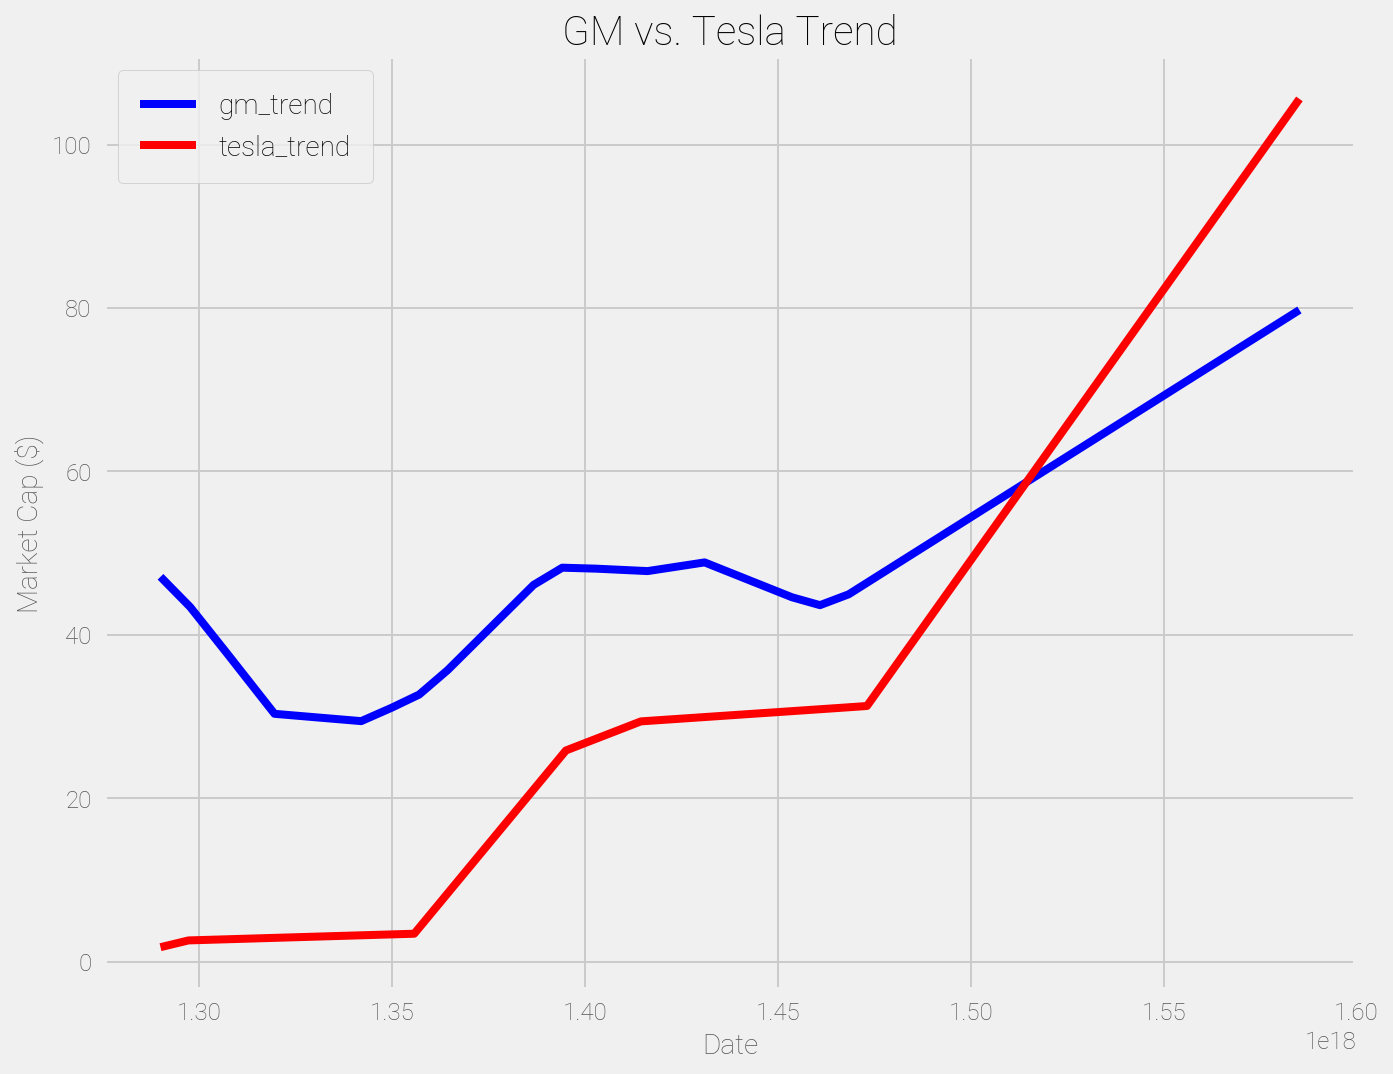

In [195]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_trend'], 'b-')
plt.plot(forecast['Date'], forecast['tesla_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Market Cap ($)')
plt.title('GM vs. Tesla Trend'); 

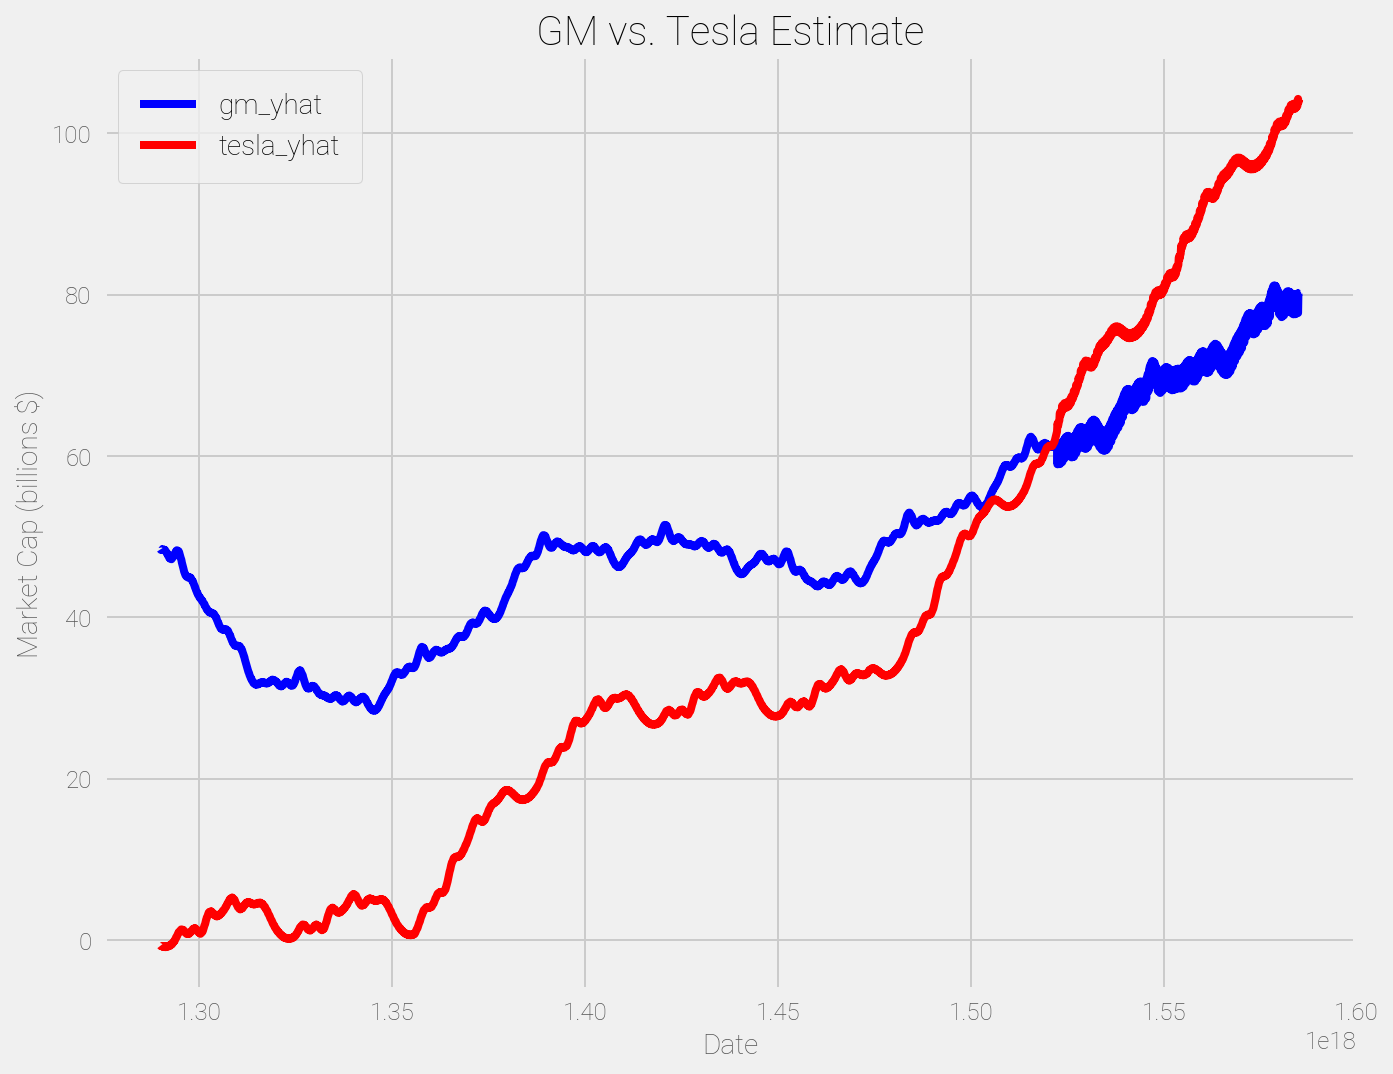

In [196]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['tesla_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)')
plt.title('GM vs. Tesla Estimate'); 

In [197]:
overtake_date = min(forecast.ix[forecast['tesla_yhat'] > forecast['gm_yhat'], 'Date'])
print('Tesla overtakes GM on {}'.format(overtake_date))

Tesla overtakes GM on 2018-03-06 00:00:00


## Forecast with Uncertainty Bounds

In [198]:
# Only keep years 2011 onwards and from before 2020
forecast = forecast[forecast['Date'] > '2010-12-31']
forecast = forecast[forecast['Date'] < '2020-01-01']

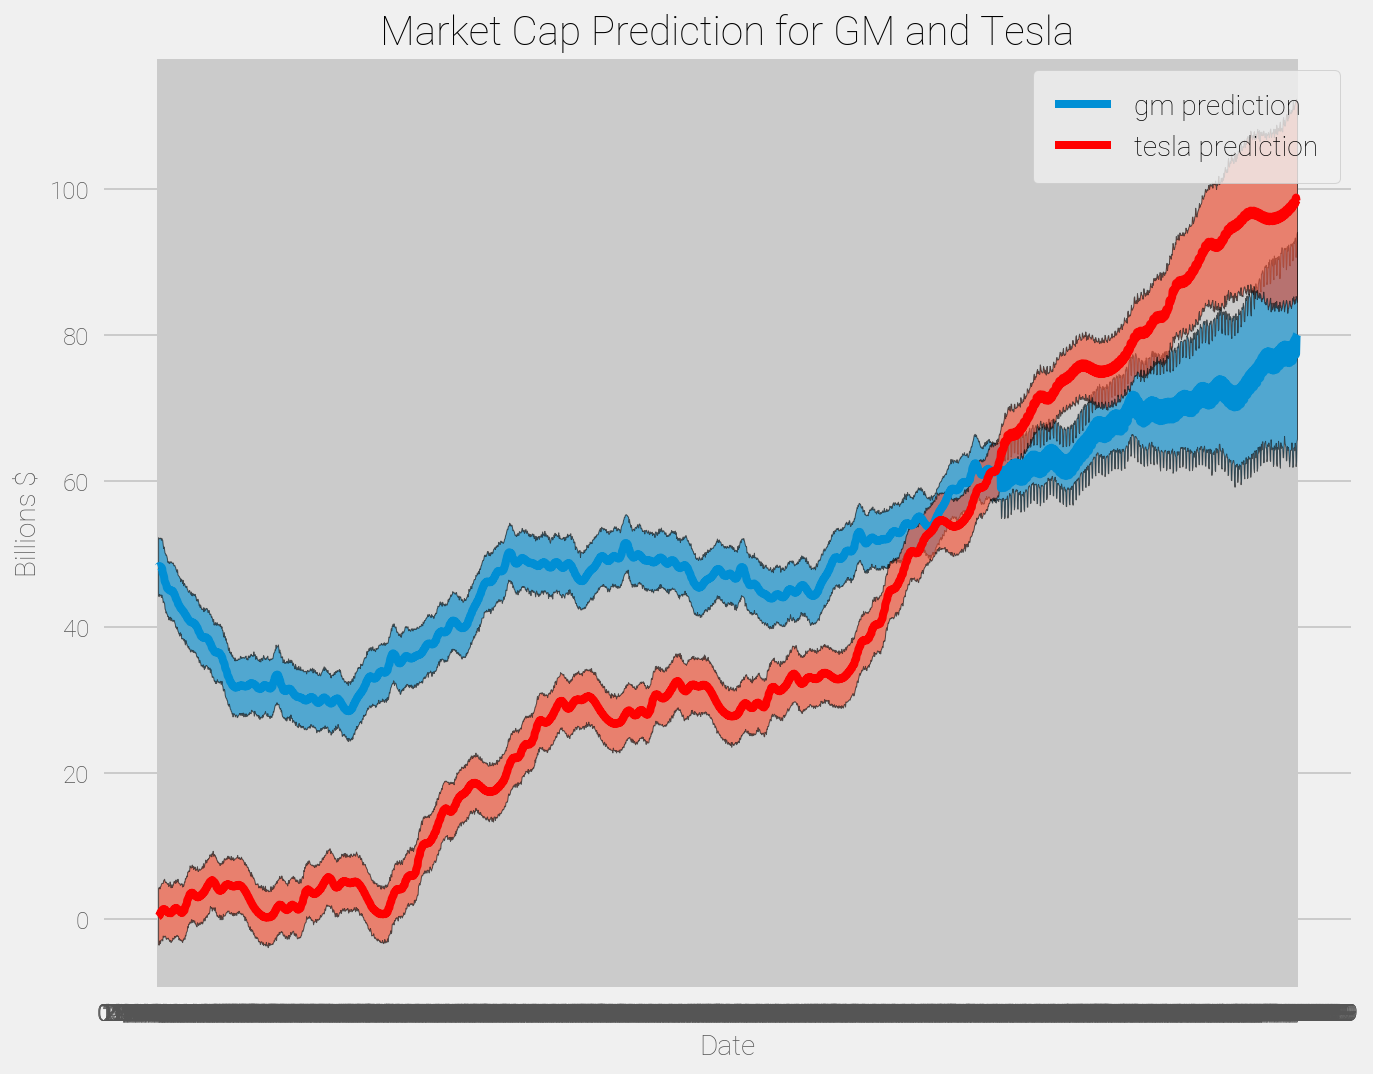

In [199]:
# Create subplots to set figure size
fig, ax = plt.subplots(1, 1, figsize=(10, 8));
xvals = range(forecast['Date'].size)
stringdate= np.vectorize(lambda x : x.strftime('%d/%m/%Y'))( forecast['Date'].dt.to_pydatetime())
#xvals = np.vectorize(lambda x : x.strftime('%d/%m/%Y'))(xvals)
# Plot estimate
ax.plot(xvals, forecast['gm_yhat'], label = 'gm prediction');

# Plot uncertainty values
ax.fill_between(xvals, forecast['gm_yhat_upper'], forecast['gm_yhat_lower'], alpha=0.6, edgecolor = 'k');

# Plot estimate and uncertainty for tesla
ax.plot(xvals, forecast['tesla_yhat'], 'r', label = 'tesla prediction');
ax.fill_between(xvals, forecast['tesla_yhat_upper'], forecast['tesla_yhat_lower'], alpha=0.6, edgecolor = 'k');
plt.xticks(xvals,stringdate);
plt.legend();
plt.xlabel('Date'); plt.ylabel('Billions $'); plt.title('Market Cap Prediction for GM and Tesla');




## Trends and Patterns

Now, we can use the Prophet Models to inspect different trends in the data. 

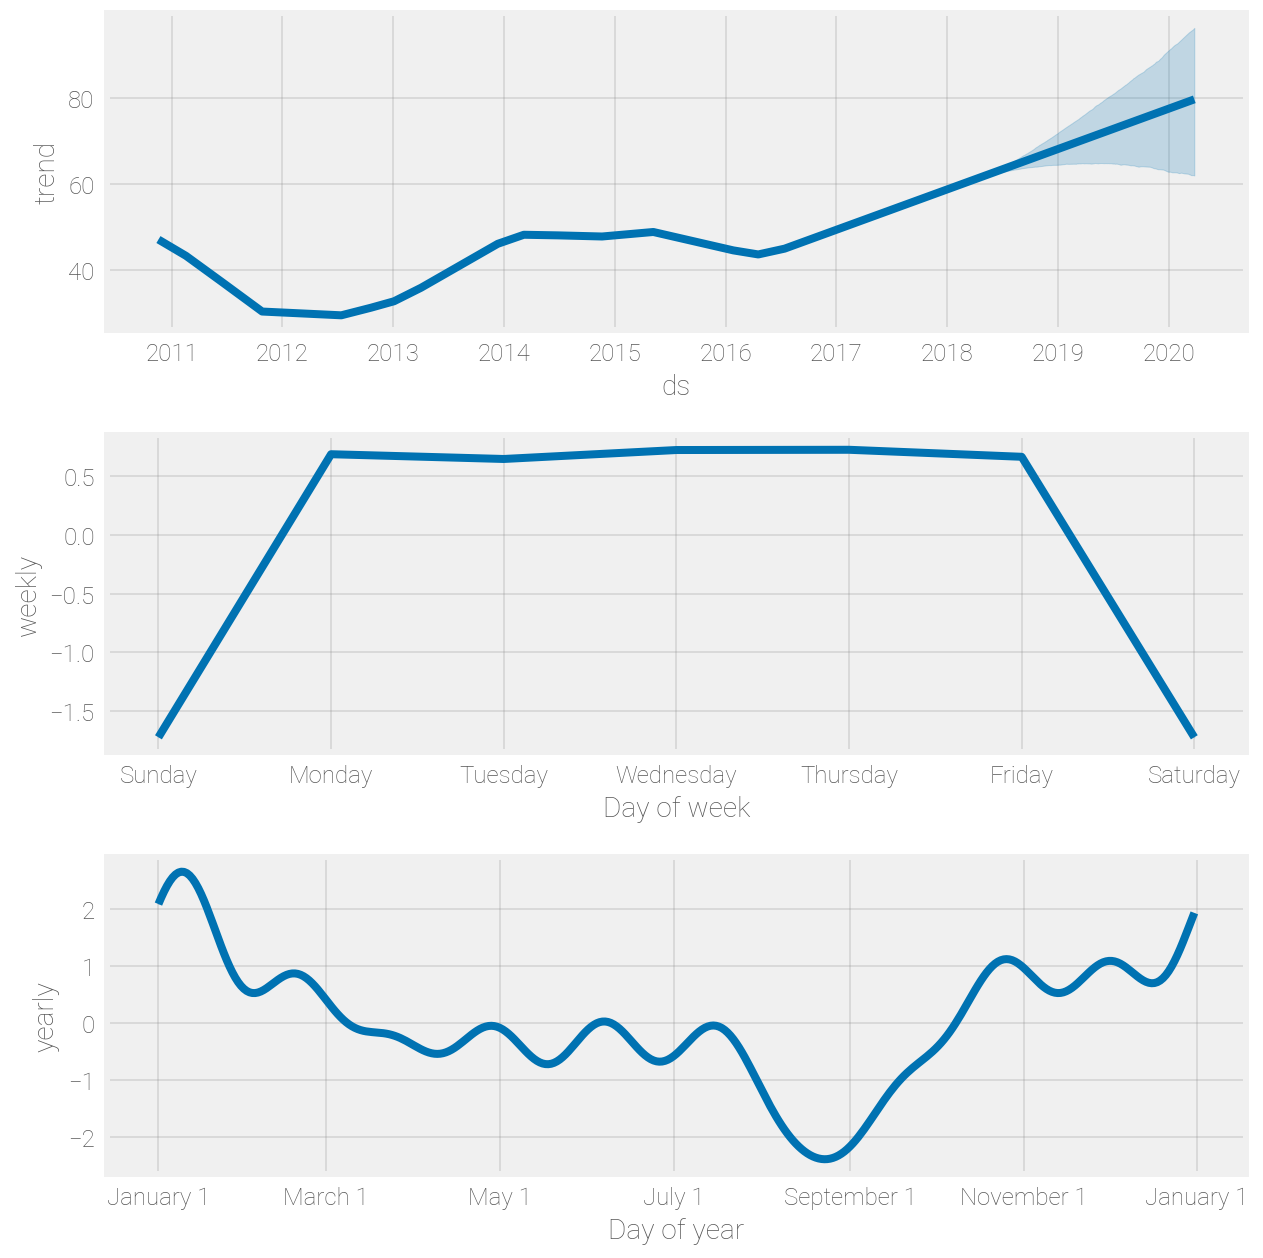

In [200]:
gm_prophet.plot_components(gm_forecast);

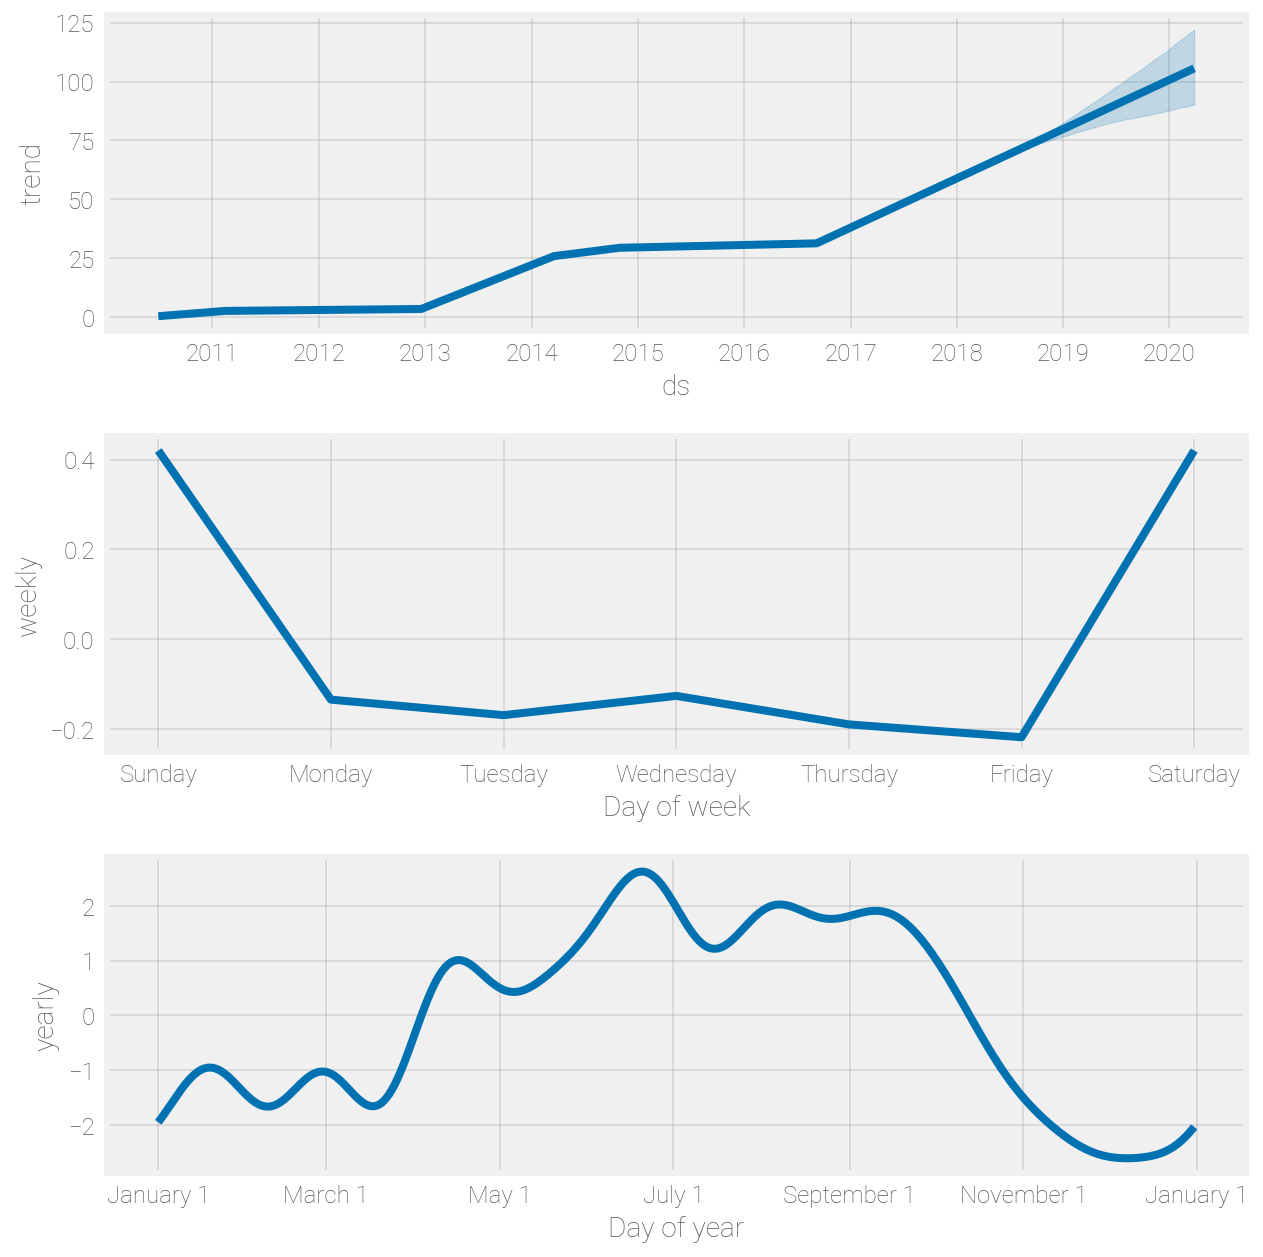

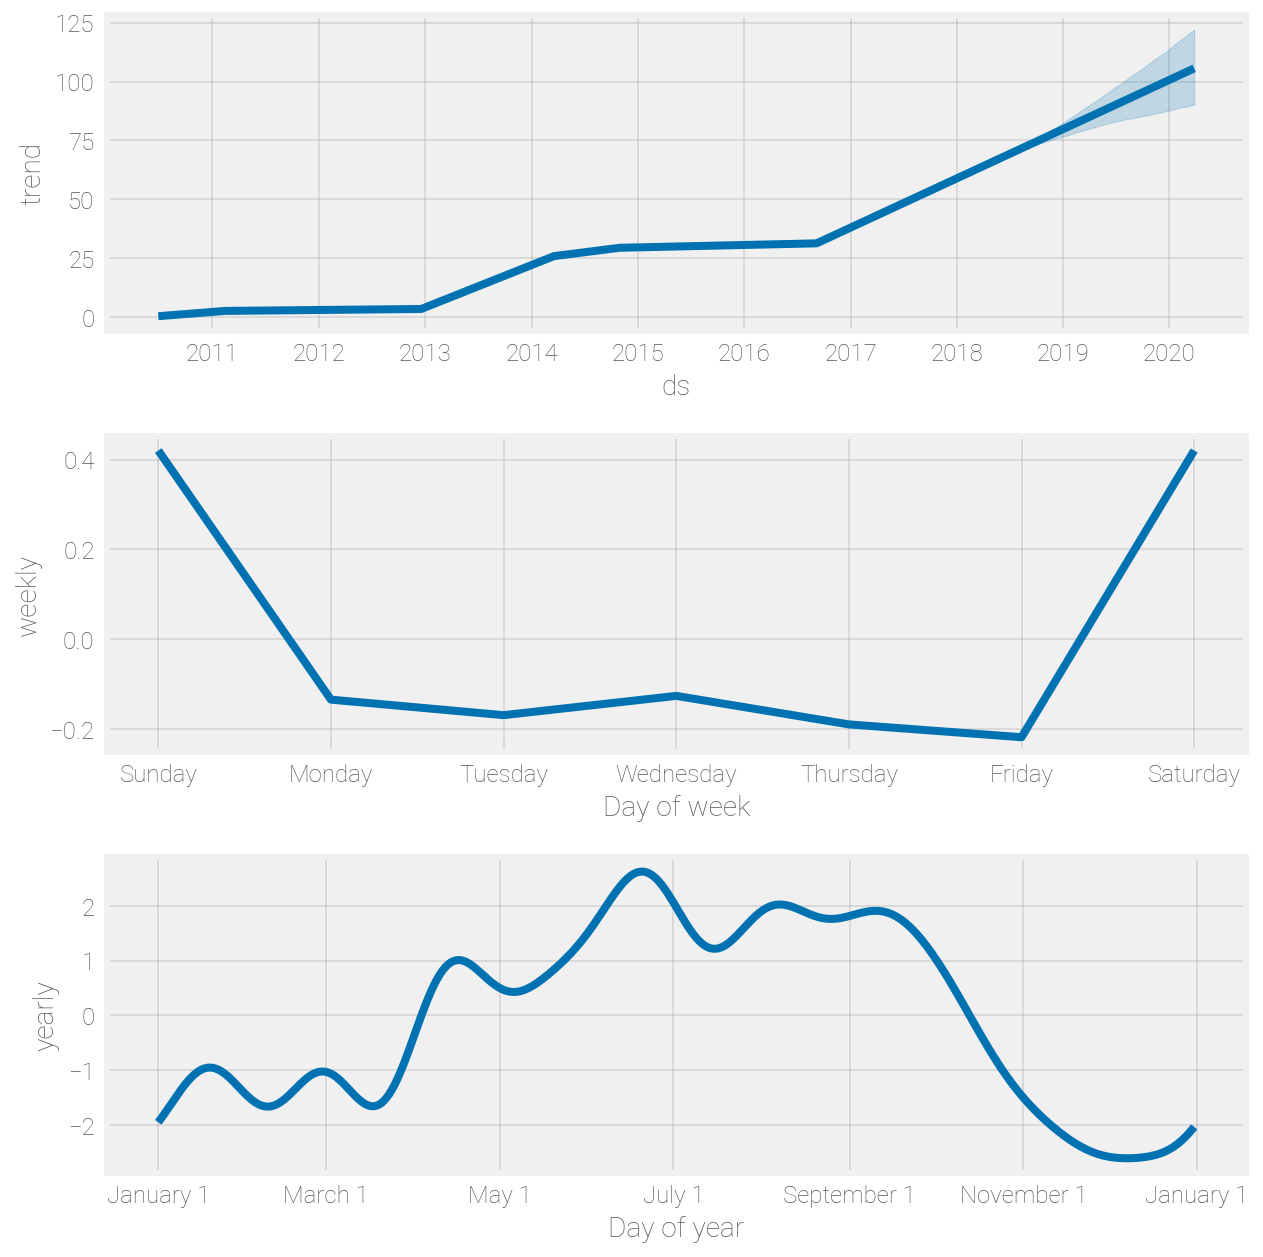

In [201]:
tesla_prophet.plot_components(tesla_forecast)

These graphs show that Tesla tends to increase during the summer, and decrease during the winter, while GM plummets during the summer and increases during the winter. We could compare GM sales with these graphs to see if there is any correlation.

It does not appear as if there is much correlation between market capitalization (a proxy for share price) and sales over the course of a year.

# US vs. China Gross Domestic Product

In [202]:
# My personal api key, use your own
quandl.ApiConfig.api_key = 'zjsWNmzXjTz9DYygZPgY'

# Get data from quandl for US and China GDP
us_gdp = quandl.get('FRED/GDP', collapse='quarterly', start_date = '1950-12-31', end_date='2017-12-31')
china_gdp = quandl.get('ODA/CHN_NGDPD', collapse='yearly', start_date = '1950-12-31', end_date='2017-12-31')

#us_gdp.plot(title = 'US Gross Domestic Product', legend=None);
#plt.ylabel('Billion $'); 
#china_gdp.plot(title = 'China Gross Domestic Product', color = 'r', legend=None);
#plt.ylabel('Billion $');

In [203]:
# Change index to date column
us_gdp = us_gdp.reset_index(level=0)
us_gdp.head(5)

,Date,Value
0,1951-03-31,336.000
1,1951-06-30,344.090
2,1951-09-30,351.385
3,1951-12-31,356.178
4,1952-03-31,359.820


In [204]:
china_gdp = china_gdp.reset_index(level=0)
china_gdp.head(5)

,Date,Value
0,1980-12-31,305.348
1,1981-12-31,290.827
2,1982-12-31,286.719
3,1983-12-31,307.677
4,1984-12-31,316.628


In [205]:
# Merge the two gdp data frames and rename columns
gdp = us_gdp.merge(china_gdp, on = 'Date', how = 'left').rename(columns={'Value_x': 'US', 'Value_y': 'China'})
gdp.head(5)

,Date,US,China
0,1951-03-31,336.000,NaN
1,1951-06-30,344.090,NaN
2,1951-09-30,351.385,NaN
3,1951-12-31,356.178,NaN
4,1952-03-31,359.820,NaN


In [206]:
round(gdp.describe(), 2)

,US,China
count,268.00,38.00
mean,6108.51,2984.68
std,5873.70,3755.50
min,336.00,286.72
25%,877.39,412.84
50%,4046.93,1064.86
75%,10503.73,4346.08
max,19918.91,12062.28


In [207]:
# Fill in missing China observations using backward fill
gdp = gdp.fillna(method='bfill')

## Visualize the data

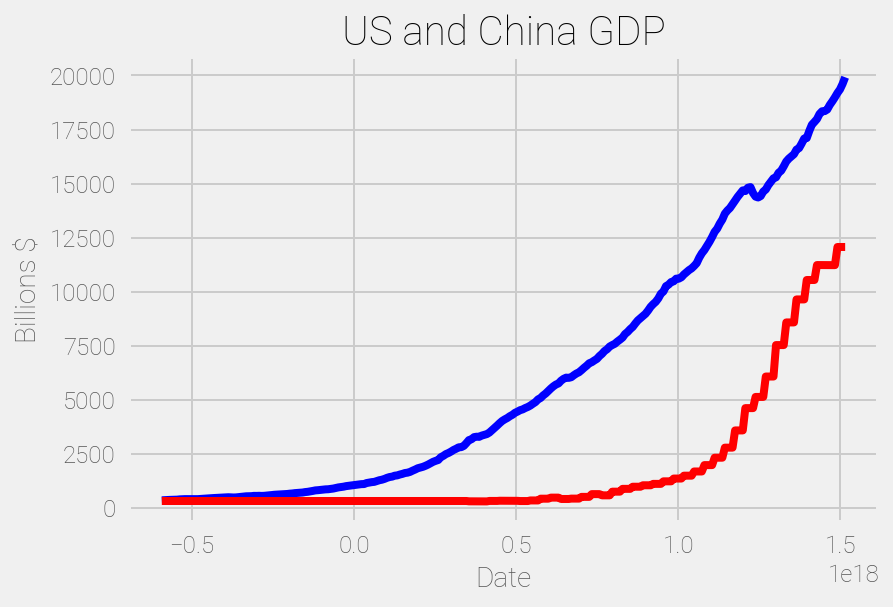

In [208]:
plt.plot(gdp['Date'], gdp['US'], label = 'US', color =  'b')
plt.plot(gdp['Date'], gdp['China'], label = 'China', color = 'r')
plt.ylabel('Billions $'); plt.title('US and China GDP'); plt.xlabel('Date');

## Make Predictions of Future GDP

In [209]:
# Create a prophet object for each dataframe
us_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2)
china_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2)

# Prophet needs dataframes with a ds (date) and y (variable) column
# Use pandas rename functionality (format is dictionary with {'old': 'new'})
us_gdp = us_gdp.rename(columns={'Date': 'ds', 'Value': 'y'})
china_gdp = china_gdp.rename(columns={'Date': 'ds', 'Value': 'y'})

In [210]:
us_prophet.fit(us_gdp);
china_prophet.fit(china_gdp);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [211]:
us_prophet.changepoints

9     1953-06-30
17    1955-06-30
26    1957-09-30
34    1959-09-30
43    1961-12-31
51    1963-12-31
60    1966-03-31
68    1968-03-31
77    1970-06-30
85    1972-06-30
94    1974-09-30
102   1976-09-30
111   1978-12-31
119   1980-12-31
128   1983-03-31
136   1985-03-31
145   1987-06-30
153   1989-06-30
162   1991-09-30
170   1993-09-30
179   1995-12-31
187   1997-12-31
196   2000-03-31
204   2002-03-31
213   2004-06-30
Name: ds, dtype: datetime64[ns]

In [212]:
# Make a future dataframe with 50 years of observations 
# US dataframe and predictions
us_forecast = us_prophet.make_future_dataframe(periods = 50, freq = 'Y')
us_forecast = us_prophet.predict(us_forecast)

# China dataframe and predictions
china_forecast = china_prophet.make_future_dataframe(periods = 50, freq = 'Y')
china_forecast = china_prophet.predict(china_forecast)

## Plot Future Predictions

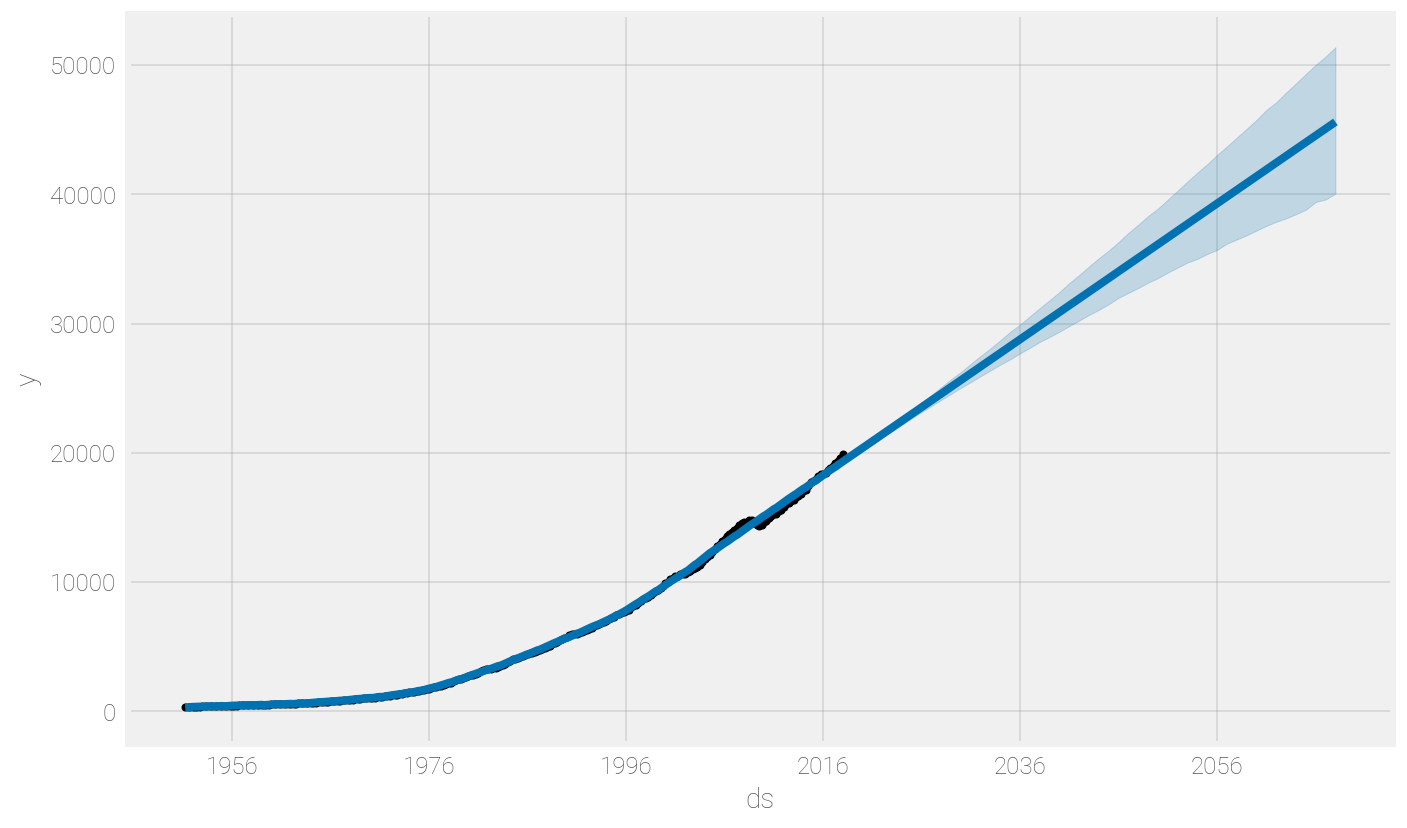

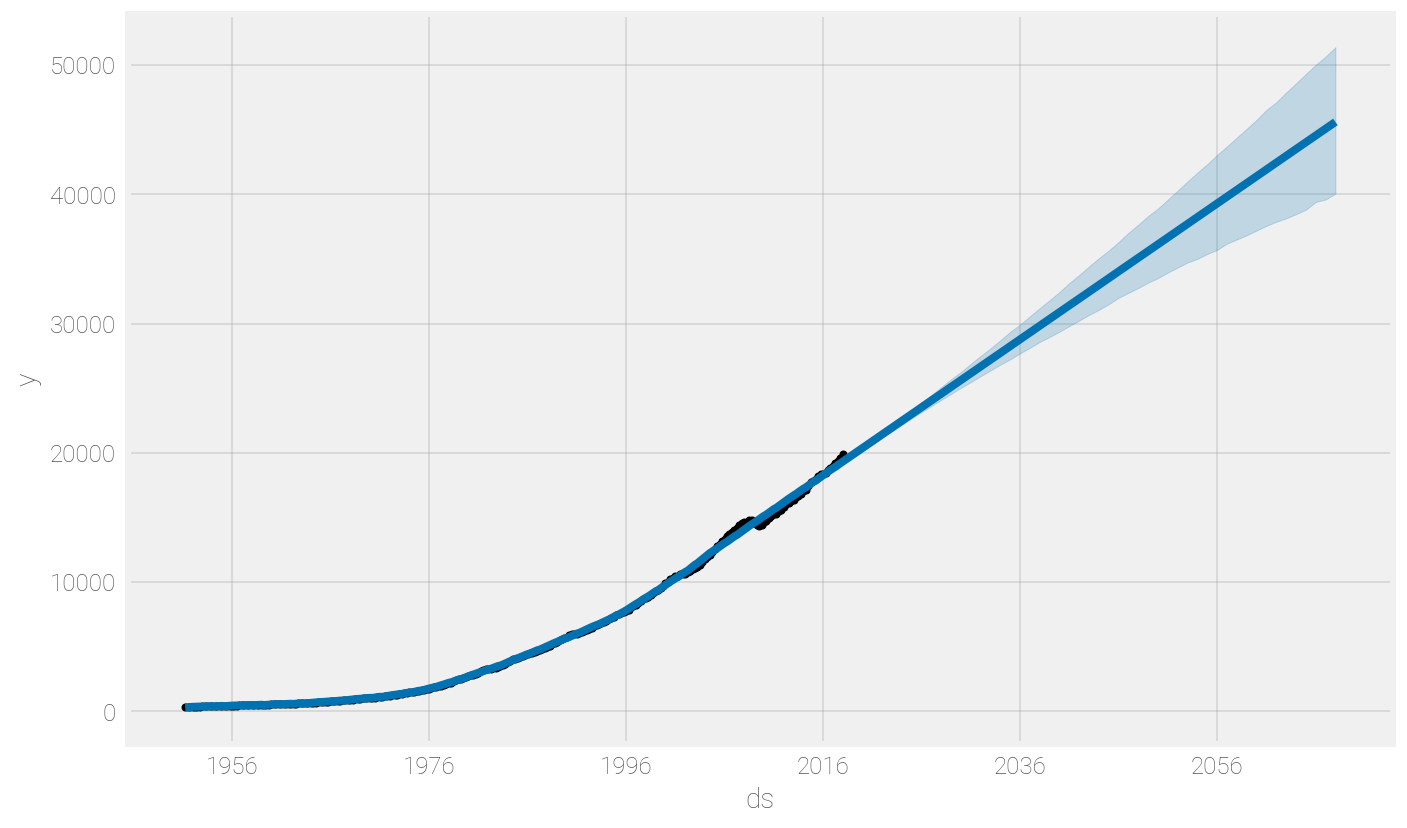

In [213]:
us_prophet.plot(us_forecast)

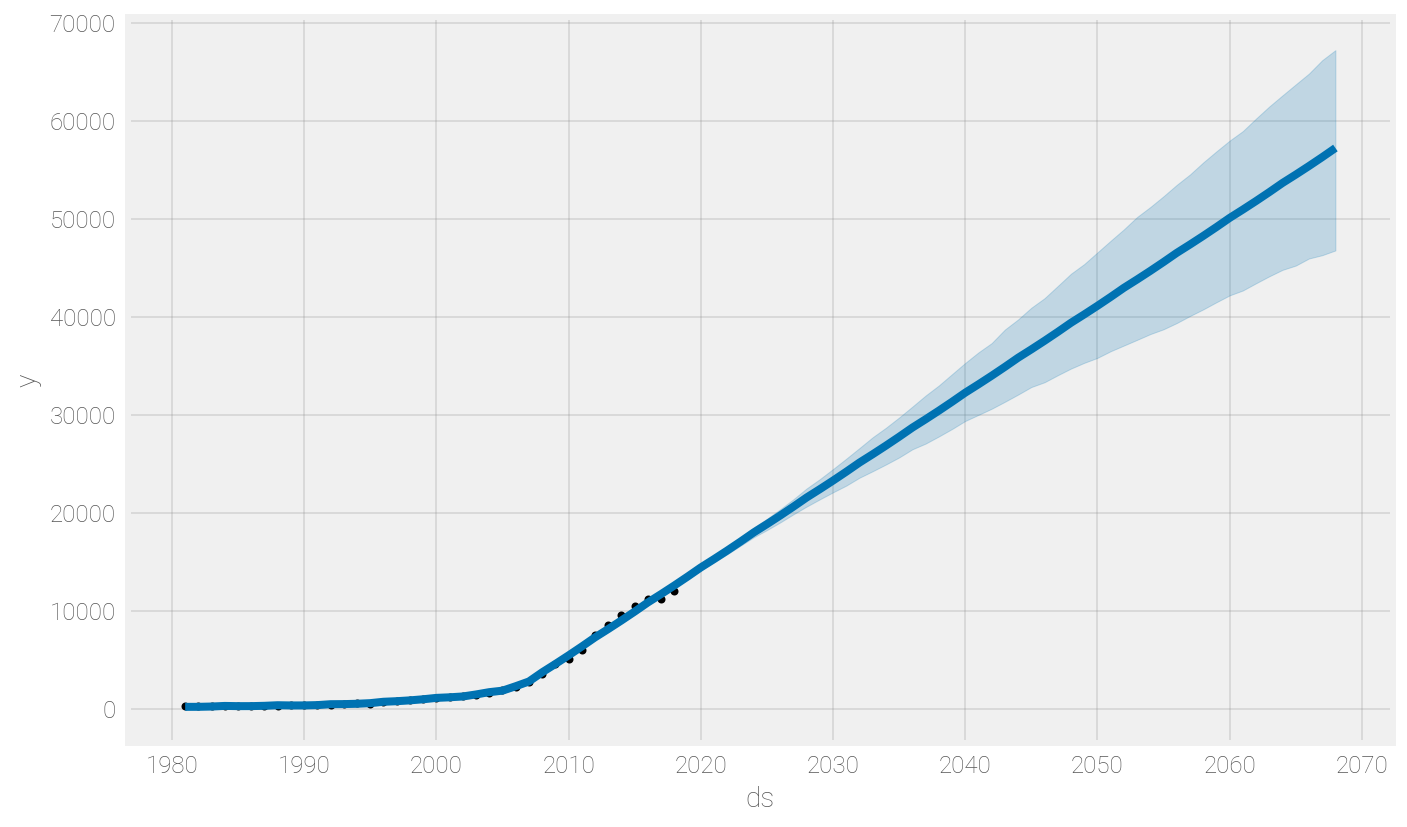

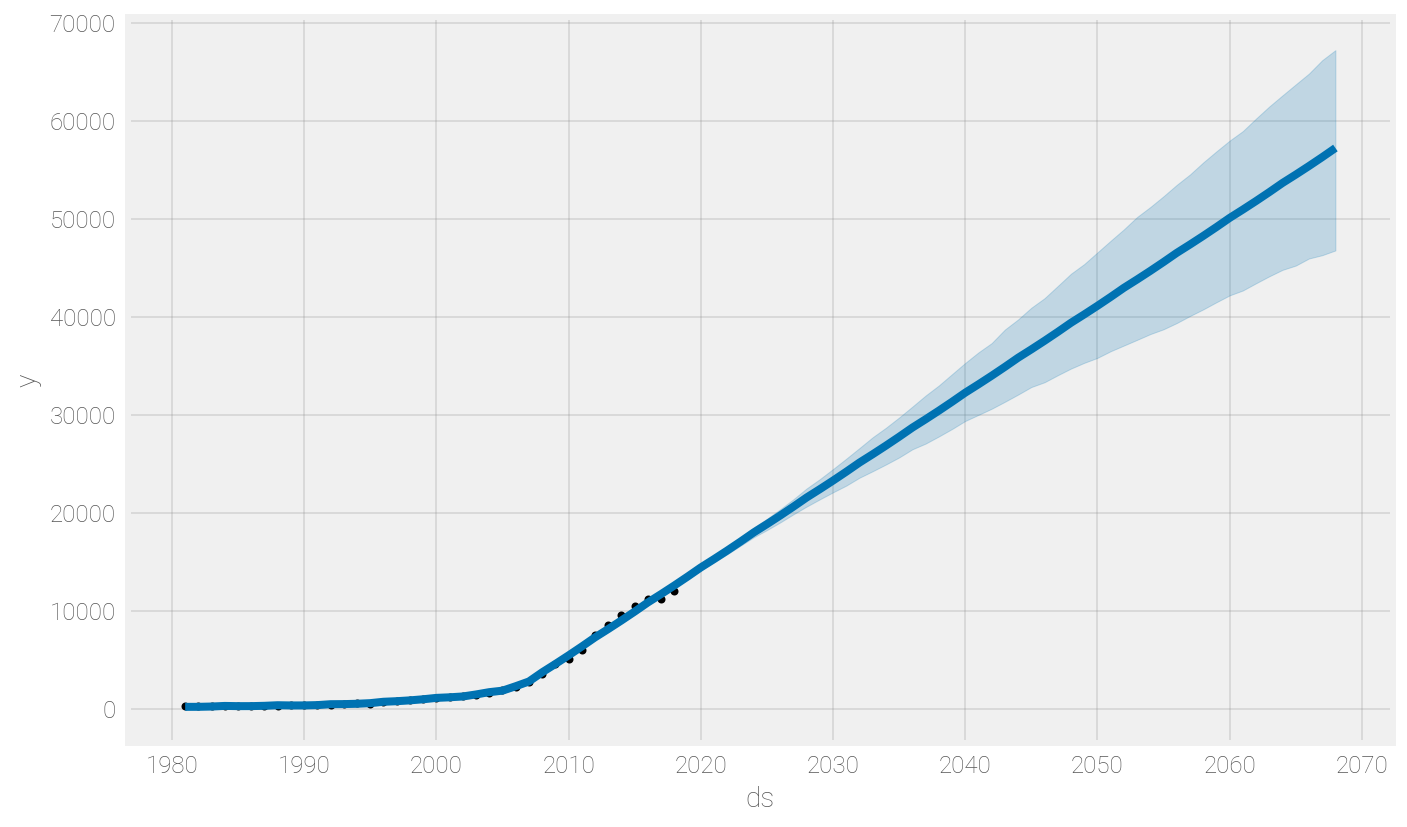

In [214]:
china_prophet.plot(china_forecast)

# When will China Overtake the United States?

In [215]:
us_names = ['us_%s' % column for column in us_forecast.columns]
china_names = ['china_%s' % column for column in china_forecast.columns]

# Dataframes to merge
merge_us_forecast = us_forecast.copy()
merge_china_forecast = china_forecast.copy()

# Rename the columns
merge_us_forecast.columns = us_names
merge_china_forecast.columns = china_names

In [216]:
# Merge the two datasets
gdp_forecast = pd.merge(merge_us_forecast, merge_china_forecast, how = 'inner', left_on = 'us_ds', right_on = 'china_ds')

# Rename date column
gdp_forecast = gdp_forecast.rename(columns={'us_ds': 'Date'}).drop('china_ds', axis=1)
gdp_forecast.head()

,Date,us_trend,us_yhat_lower,us_yhat_upper,us_trend_lower,us_trend_upper,us_additive_terms,us_additive_terms_lower,us_additive_terms_upper,us_yearly,...,china_additive_terms,china_additive_terms_lower,china_additive_terms_upper,china_yearly,china_yearly_lower,china_yearly_upper,china_multiplicative_terms,china_multiplicative_terms_lower,china_multiplicative_terms_upper,china_yhat
0,1980-12-31,3389.904904,2755.296026,3194.239897,3389.904904,3389.904904,-408.255621,-408.255621,-408.255621,-408.255621,...,-1109.548512,-1109.548512,-1109.548512,-1109.548512,-1109.548512,-1109.548512,0.0,0.0,0.0,240.200573
1,1981-12-31,3651.724376,3016.905238,3463.627021,3651.724376,3651.724376,-410.312537,-410.312537,-410.312537,-410.312537,...,-1124.805925,-1124.805925,-1124.805925,-1124.805925,-1124.805925,-1124.805925,0.0,0.0,0.0,242.949634
2,1982-12-31,3913.543849,3286.604451,3725.292539,3913.543849,3913.543849,-411.896266,-411.896266,-411.896266,-411.896266,...,-1111.435653,-1111.435653,-1111.435653,-1111.435653,-1111.435653,-1111.435653,0.0,0.0,0.0,274.326379
3,1983-12-31,4211.243922,3587.332160,4011.643303,4211.243922,4211.243922,-413.003531,-413.003531,-413.003531,-413.003531,...,-1069.470638,-1069.470638,-1069.470638,-1069.470638,-1069.470638,-1069.470638,0.0,0.0,0.0,334.297868
4,1984-12-31,4521.534525,3888.606382,4322.785527,4521.534525,4521.534525,-408.255621,-408.255621,-408.255621,-408.255621,...,-1109.548512,-1109.548512,-1109.548512,-1109.548512,-1109.548512,-1109.548512,0.0,0.0,0.0,312.275801


## Future Plot with Uncertainty

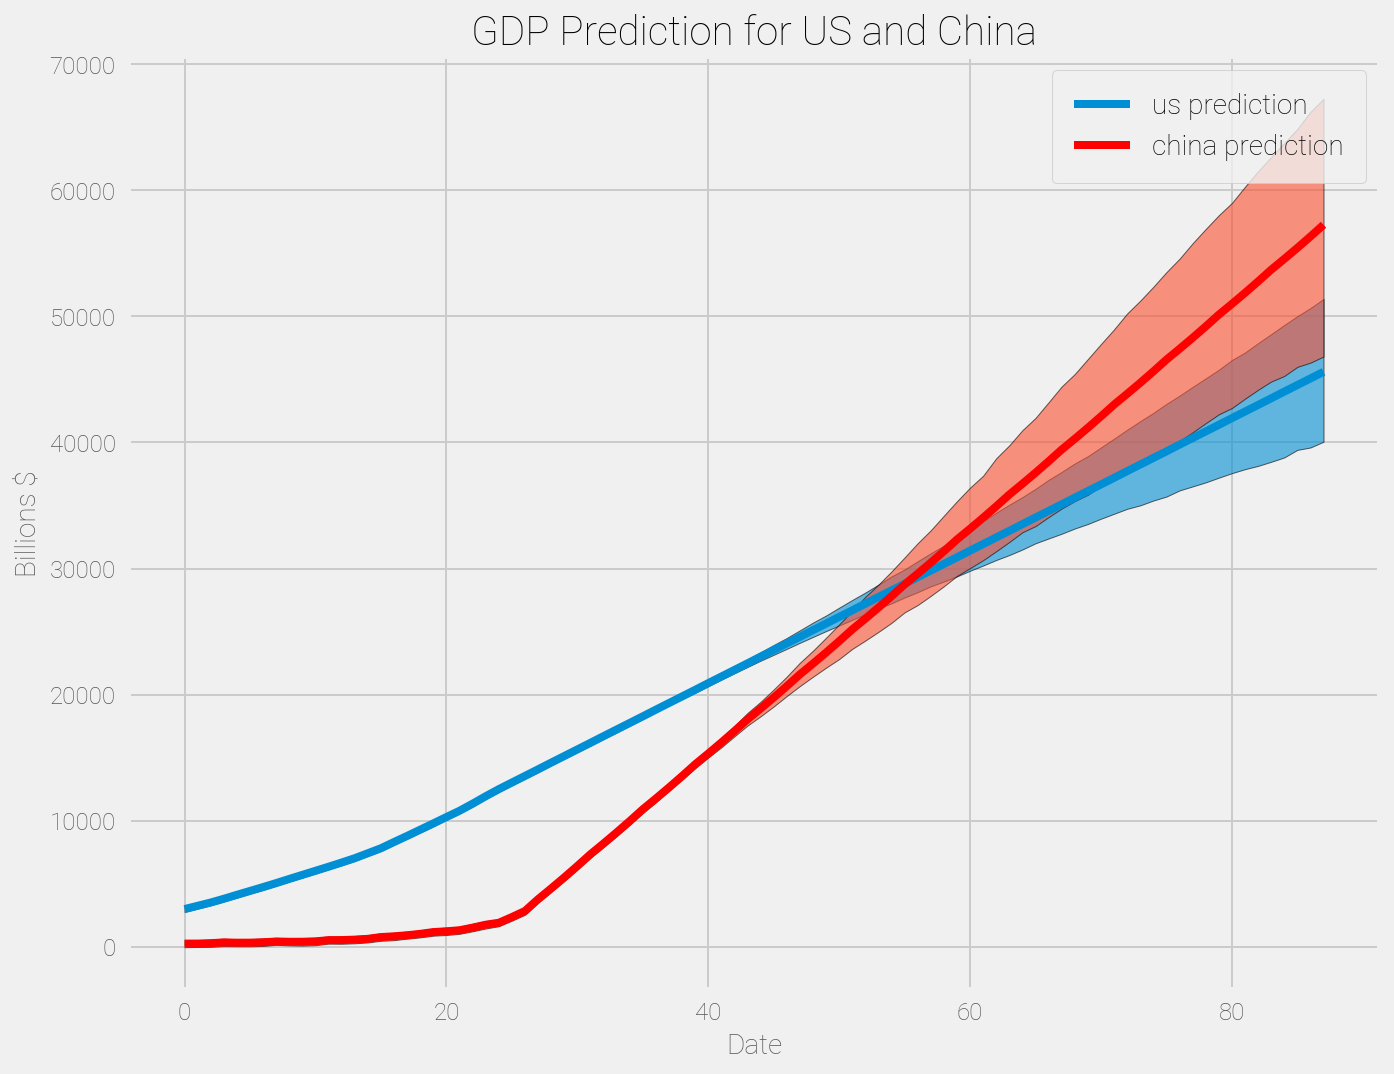

In [217]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8));
xvals = range(gdp_forecast['Date'].size)
stringdate= np.vectorize(lambda x : x.strftime('%d/%m/%Y'))( gdp_forecast['Date'].dt.to_pydatetime())
ax.plot(xvals, gdp_forecast['us_yhat'], label = 'us prediction');
ax.fill_between(xvals, gdp_forecast['us_yhat_upper'], gdp_forecast['us_yhat_lower'], alpha=0.6, edgecolor = 'k');
ax.plot(xvals, gdp_forecast['china_yhat'], 'r', label = 'china prediction');
ax.fill_between(xvals, gdp_forecast['china_yhat_upper'], gdp_forecast['china_yhat_lower'], alpha=0.6, edgecolor = 'k');
plt.legend();
plt.xlabel('Date'); plt.ylabel('Billions $'); plt.title('GDP Prediction for US and China');


In [218]:
first_pass = min(gdp_forecast.ix[gdp_forecast['us_yhat'] < gdp_forecast['china_yhat'], 'Date'])
print('China will overtake the US in GDP on {}.'.format(first_pass))

China will overtake the US in GDP on 2036-12-31 00:00:00.


In [219]:
!jupyter nbconvert --to PYTHON Financial_Time_Series_Forecast.ipynb

[NbConvertApp] Converting notebook Financial_Time_Series_Forecast.ipynb to PYTHON
[NbConvertApp] Writing 14577 bytes to Financial_Time_Series_Forecast.py
